In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/IFT6758/ift6758-project-template-main"
os.chdir(path)

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import datetime

Mounted at /content/drive


# **Part 2**

## **Data**
Get 2015-2019 regular season data for train and validation, 2019-2020 regular data for test

In [ ]:
def getData():
  """
  Retruns the data from 2015 to 2018 for training and validation, 2019 for testing
  Input: None
  Output: 
  - two arrays of shape (m x n), (m x q)
  """
  df15r = pd.read_csv('./2015R.csv')
  df16r = pd.read_csv('./2016R.csv')
  df17r = pd.read_csv('./2017R.csv')
  df18r = pd.read_csv('./2018R.csv')
  df19r = pd.read_csv('./2019R.csv')

  frames = [df15r, df16r, df17r, df18r]
  df_dataset_R = pd.concat(frames)
  df_dataset_R = df_dataset_R.drop(['Unnamed: 0'], axis=1)
  df_dataset_R = df_dataset_R.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
  
  df_test_R = df19r
  df_test_R = df_test_R.drop(['Unnamed: 0'], axis=1)
  df_test_R = df_test_R.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
  return (df_dataset_R,df_test_R)

df_dataset_R,df_test_R = getData()

For mileStone2 dataset add new feature:
-	Distance from net
-	Angle from net
-	Is goal (0 or 1)
-	Empty Net (0 or 1; you can assume NaNs are 0)

In [ ]:
def get_goal_coordinates(rinkSide, opposite = False): 
    """
    Input: 
    - rinkSide: The column "rinkSide" which is part of the dataframe; indicates which side of the rink the home-team starts (period == 1) 
    - opposite: boolean
    Output: 
    - An array of shape (1 x 2); [x, y];  containing the coordinates of the goal post
    """
    left_goal = np.array([-89, 0])
    right_goal = np.array([89, 0]) 
    if opposite == False: 
        if rinkSide == "left": 
            return right_goal
        else: 
            return left_goal
    else: 
        if rinkSide == "left": 
            return left_goal
        else: 
            return right_goal
                         
def get_shot_distance(df2): 
    """
    Returns the distance of shot from the (target) goal for each shot in the dataframe
    Input: 
    - df2: dataframe; shape (m x n) 
    Output: 
    - np-array; shape (m x 1) 
    """
    df2 = df2.reset_index(drop=True)
    distance = []
    for shot in range(len(df2)): 
        shot_coordinates = np.array([df2.loc[shot, 'coordinates x'], df2.loc[shot, 'coordinates y']])
        if (df2.loc[shot, 'period num'].item() % 2) == 1: 
            if df2.loc[shot, 'team name'] == df2.loc[shot, 'home name']:
                distance.append(np.linalg.norm(shot_coordinates - get_goal_coordinates(df2.loc[shot, 'rinkSide'], opposite = False)))
            else: 
                distance.append(np.linalg.norm(shot_coordinates - get_goal_coordinates(df2.loc[shot, 'rinkSide'], opposite = True)))
        else: 
            if df2.loc[shot, 'team name'] == df2.loc[shot, 'home name']:# rinkSide
                distance.append(np.linalg.norm(shot_coordinates - get_goal_coordinates(df2.loc[shot, 'rinkSide'], opposite = True)))
            else: 
                distance.append(np.linalg.norm(shot_coordinates - get_goal_coordinates(df2.loc[shot, 'rinkSide'], opposite = False)))
            
    return distance

In [ ]:
def get_direction(shot):
  """
  Return to the side of the net to which the shot was directed
  input:
  - shot: a row of dataframe; shape (m x 1)
  Output:
  - bool: True for the left side, False for the right side
  """
  if (shot['period num'].item() % 2) == 1:
    if (shot['team name'] == shot['home name'] and shot['rinkSide'] == 'right') or (shot['team name'] == shot['away name'] and shot['rinkSide'] == 'left'):
      return True
    else:
      return False
  else:
    if (shot['team name'] == shot['home name'] and shot['rinkSide'] == 'right') or (shot['team name'] == shot['away name'] and shot['rinkSide'] == 'left'):
      return False
    else:
      return True

def get_shot_angle(df2): 
  """
  Returns the angle of shot from the (target) goal for each shot in the dataframe
  left goal net: Clockwise [0,360]
  right goal net: anticlockwise [0,360]
  Input: 
  - df2: dataframe; shape (m x n) 
  Output: 
  - np-array; shape (m x 1) 
  """
  df2 = df2.reset_index(drop=True)
  angle = []
  for shot in range(len(df2)): 
      if(df2.loc[shot, 'Distance from net'] == 0):
          angle.append(0)
      else:
          if get_direction(df2.loc[shot]):
              if df2.loc[shot, 'coordinates x'] >= -89:
                  angle.append(np.degrees(np.arccos(df2.loc[shot, 'coordinates y'] / df2.loc[shot, 'Distance from net'])))
              else:
                  angle.append(180 + np.degrees(np.arccos( - df2.loc[shot, 'coordinates y'] / df2.loc[shot, 'Distance from net'])))
          else:
              if df2.loc[shot, 'coordinates x'] <= 89:
                  angle.append(np.degrees(np.arccos( - df2.loc[shot, 'coordinates y'] / df2.loc[shot, 'Distance from net'])))
              else:
                  angle.append(180 + np.degrees(np.arccos(df2.loc[shot, 'coordinates y'] / df2.loc[shot, 'Distance from net'])))
  return angle
                  

               


In [ ]:
def addNewCol(df):
  '''
  Adding four new features: Distance from net, Angle from net, is goal, Empty Net
  Input: an array of shape (m x n)
  Output: an array of shape ((m+4) x n)
  '''
  #Distance from net
  distances = [] 
  for name,group in df.groupby('season'):
    distances.append(get_shot_distance(group))  
  df.insert(20, 'Distance from net', distances[0])

  #Angle from net
  angles = []
  for _,group in df.groupby('season'):
    angles.append(get_shot_angle(group))  
  df.insert(21, 'Angle from net', angles[0])

  #is goal(0 or 1)
  isGoal = []
  shot_or_goal = df['shot or goal'].tolist()
  for i in shot_or_goal:
    if i == 'Goal':
      isGoal.append(1)
    else:
      isGoal.append(0)
  df.insert(22, 'Is goal', isGoal)

  #Empty Net (0 or 1; NaNs are 0)
  isEmptyNet = []
  empty_net = df['empty net'].tolist()
  for i in empty_net:
    if i == 'True':
      isEmptyNet.append(1)
    else:
      isEmptyNet.append(0)
  df.insert(23, 'Empty Net', isEmptyNet)
  df = df.drop(['empty net'],axis = 1)
  return df

#addNewCol(df_dataset_R)
#df_dataset_R = df_dataset_R.reset_index(drop=True)

In [ ]:
#addNewCol(df_dataset_R)
#df_dataset_R = df_dataset_R.reset_index(drop=True)
#df_dataset_R.to_csv('./Milestone2_newData.csv')

#addNewCol(df_test_R)
#df_test_R = df_test_R.reset_index(drop=True)
#df_test_R.to_csv('./Milestone2_newTestData.csv')

,period time,period time remaining,date time,period num,event Id,game ID,season,team ID,team name,shot or goal,coordinates x,coordinates y,shooter,goalie,shot type,strength,empty net,home name,away name,rinkSide,Distance from net,Angle from net,Is goal,Empty Net
0,00:25,19:35,2019-10-02 23:15:32,1,10,2019020001,20192020,9.0,Ottawa Senators,Goal,85.0,-1.0,NaN,Frederik Andersen,Tip-In,Even,False,Toronto Maple Leafs,Ottawa Senators,right,4.123106,75.963757,1,0
1,01:31,18:29,2019-10-02 23:18:23,1,15,2019020001,20192020,10.0,Toronto Maple Leafs,Shot,-32.0,-2.0,Morgan Rielly,Craig Anderson,Snap Shot,NaN,NaN,Toronto Maple Leafs,Ottawa Senators,right,57.035077,92.009554,0,0
2,03:23,16:37,2019-10-02 23:20:45,1,20,2019020001,20192020,9.0,Ottawa Senators,Shot,63.0,-6.0,Dylan DeMelo,Frederik Andersen,Snap Shot,NaN,NaN,Toronto Maple Leafs,Ottawa Senators,right,26.683328,77.005383,0,0
3,03:56,16:04,2019-10-02 23:21:17,1,21,2019020001,20192020,10.0,Toronto Maple Leafs,Shot,-59.0,-20.0,Morgan Rielly,Craig Anderson,Wrist Shot,NaN,NaN,Toronto Maple Leafs,Ottawa Senators,right,36.055513,123.690068,0,0
4,04:47,15:13,2019-10-02 23:22:36,1,24,2019020001,20192020,10.0,Toronto Maple Leafs,Shot,-42.0,-29.0,Tyson Barrie,Craig Anderson,Slap Shot,NaN,NaN,Toronto Maple Leafs,Ottawa Senators,right,55.226805,121.675469,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66041,16:45,03:15,2020-03-12 04:56:38,3,773,2019021082,20192020,9.0,Ottawa Senators,Shot,77.0,-23.0,Nick Paul,Calvin Petersen,Backhand,NaN,NaN,Los Angeles Kings,Ottawa Senators,right,25.942244,27.552812,0,0
66042,17:20,02:40,2020-03-12 04:57:13,3,774,2019021082,20192020,26.0,Los Angeles Kings,Shot,-76.0,38.0,Drew Doughty,Craig Anderson,Slap Shot,NaN,NaN,Los Angeles Kings,Ottawa Senators,right,40.162171,18.886087,0,0
66043,17:22,02:38,2020-03-12 04:57:16,3,537,2019021082,20192020,26.0,Los Angeles Kings,Shot,-79.0,10.0,Gabriel Vilardi,Craig Anderson,Backhand,NaN,NaN,Los Angeles Kings,Ottawa Senators,right,14.142136,45.000000,0,0
66044,18:50,01:10,2020-03-12 04:59:06,3,777,2019021082,20192020,9.0,Ottawa Senators,Shot,81.0,-7.0,Thomas Chabot,Calvin Petersen,Snap Shot,NaN,NaN,Los Angeles Kings,Ottawa Senators,right,10.630146,48.814075,0,0


## **Histograms**
### Separate goal ans non goal

In [ ]:
goal = df_dataset_R[df_dataset_R['shot or goal'] == 'Goal'] 
nonGoal = df_dataset_R[df_dataset_R['shot or goal'] == 'Shot']

### A histogram of shot counts (goals and no-goals separated), binned by distance ‼️

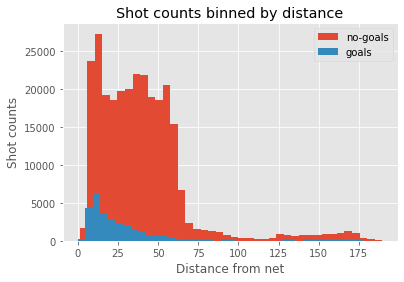

In [ ]:
plt.style.use('ggplot')
plt.hist(nonGoal['Distance from net'].tolist(), bins=40, alpha=1, label = 'no-goals')
plt.hist(goal['Distance from net'].tolist(), bins=40, alpha=1, label = 'goals')
plt.xlabel('Distance from net')
plt.ylabel('Shot counts')
plt.title('Shot counts binned by distance')
plt.legend()
plt.show()

From this histogram, it is easy to conclude that most of the shots are concentrated in the range of 5 to 65. The majority of these goals are concentrated in the range of 5 to 30. Therefore, we can conclude that shots and goals in the game are mainly from short distances.

### A histogram of shot counts (goals and no-goals separated), binned by angle ‼️

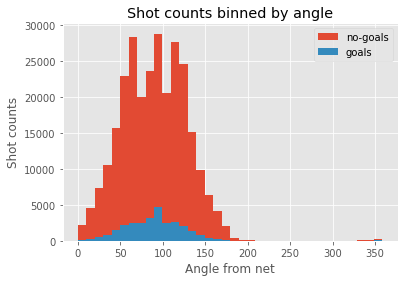

In [ ]:
plt.style.use('ggplot')
plt.hist(nonGoal['Angle from net'].tolist(), bins=36, alpha=1, label = 'no-goals')
plt.hist(goal['Angle from net'].tolist(), bins=36, alpha=1, label = 'goals')
plt.xlabel('Angle from net')
plt.ylabel('Shot counts')
plt.title('Shot counts binned by angle')
plt.legend()
plt.show()

This histogram indicates that the majority of shot angles are concentrated in the range of 40 degrees to 150 degrees. The vast majority of these goal angles are also concentrated in this range. In particular, the greatest number of goals were scored in a direction almost perpendicular to the goal net (around 90 degrees). In addition, a very small number of shots and goals were shot from the back of the net.

### A 2D histogram where one axis is the distance and the other is the angle.  Do not need to separate goals and no-goals ‼️

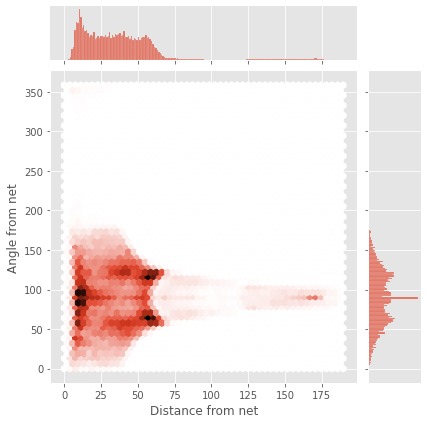

In [ ]:
import seaborn as sns
df_dataset_R = df_dataset_R.reset_index(drop=True)
tips = sns.load_dataset("tips")
g = sns.jointplot(x="Distance from net", y="Angle from net", data= df_dataset_R, kind="hex")

The 2D histogram shows that the vast majority of shots were taken from a distance of 5ft to 60ft from the goal, and from an angle of 40 to 150 degrees.

# **Part 4**

### Question 1
### Select feautures
*   Game seconds
*   Game period
*   Coordinates X (x,y, separate columns)
*   Coordinates Y (x,y, separate columns)
*   Shot distance
*   Shot angle
*   Shot type

In [ ]:
def timeToSec(time, per):
  secs = []
  for i in range(len(time)):
    sec = datetime.datetime.strptime(time[i], '%M:%S').minute*60 + datetime.datetime.strptime(time[i], '%M:%S').second
    if per[i] == 1:
      secs.append(sec)
    elif per[i] == 2:
      secs.append(20*60 + sec)
    elif per[i] == 3:
      secs.append(40*60 + sec)
    elif per[i] == 4:
      secs.append(60*60 + sec)
    elif per[i] == 5:
      secs.append(65*60 + sec)
  return secs

def getData_Q4(): 
  """
  input: None
  output: dataframe with 8 columns
  """
  df_q2 = pd.read_csv('./Milestone2_newData.csv')
  secs = timeToSec(df_q2['period time'].tolist(), df_q2['period num'].tolist())
  df = df_q2[['period num', 'coordinates x', 'coordinates y', 'Distance from net', 'Angle from net', 'shot type']]
  df.insert(0, 'period time', secs)
  return df

getData_Q4()

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,shot type
0,51,1,-55.0,6.0,34.525353,79.992020,Wrist Shot
1,65,1,-79.0,0.0,10.000000,90.000000,Snap Shot
2,66,1,-75.0,-1.0,14.035669,94.085617,Snap Shot
3,113,1,-55.0,-36.0,49.517674,136.636577,Wrist Shot
4,157,1,-61.0,-1.0,28.017851,92.045408,Tip-In
...,...,...,...,...,...,...,...
303262,3337,3,67.0,-19.0,29.068884,49.184916,Slap Shot
303263,3393,3,-78.0,1.0,11.045361,84.805571,Wrist Shot
303264,3519,3,-82.0,10.0,12.206556,34.992020,Wrist Shot
303265,3520,3,-81.0,1.0,8.062258,82.874984,Wrist Shot


### Question 2
To each shot, add the following information from the immediately preceding event as four new features:     


*   Last event type 
*   Coordinates of the last event x (x, y, separate columns)
*   Coordinates of the last event y (x, y, separate columns)
*   Time from the last event (seconds)
*   Distance from the last event


In [ ]:
import json
def jsonToDataframe(fileName):
  '''
  input: str -> json fileName
  output: dataframe shape(m,n) depends on json file
  Convert the JSON file to a Dataframe
  '''
  with open(fileName,'r') as f:
    data = json.loads(f.read())
  df= pd.json_normalize(data, ['liveData', 'plays', 'allPlays'], ['gamePk'], errors='ignore')
  try:
    df = df[['about.periodTime', 'about.period', 'about.eventId', 'gamePk', 'team.name', 'result.event', 'coordinates.x', 'coordinates.y', 'result.secondaryType']]
    #df = df[(df['result.event'] == 'Shot')|(df['result.event'] == 'Goal')]
    df.insert(3, 'season', data['gameData']['game']['season'])
    df.insert(6, 'home name', data['gameData']['teams']['home']['name'])
    df.insert(7, 'away name', data['gameData']['teams']['away']['name'])
    df.insert(8, 'rinkSide', data['liveData']['linescore']['periods']['num' == 1]['home']['rinkSide'])
  except(KeyError):
    df = pd.DataFrame(columns=['about.periodTime', 'about.period', 'about.eventId', 'gamePk', 'team.name', 'result.event', 'coordinates.x', 'coordinates.y', 'result.secondaryType'])
  df = df.rename({'about.periodTime': 'period time', 'about.period': 'period num', 'about.eventId': 'event Id', 'gamePk': 'game ID', 'team.name': 'team name', 'result.event': 'shot or goal', 'coordinates.x': 'coordinates x', 'coordinates.y': 'coordinates y',  'result.secondaryType': 'shot type'},
                      axis='columns')

  return df

In [ ]:
def getPreviouEvent(df):
  '''
  input: dataframe (with all event)
  output: dataframe (with shot and goal event, and add 4 new features about previous events)
  '''
  df.insert(13, 'last event type', 'NaN')
  df.insert(14, 'last coordinates x', 'NaN')
  df.insert(15, 'last coordinates y', 'NaN')
  df.insert(16, 'Time from the last event', 'NaN')
  df.insert(17, 'last event team name', 'NaN')
  for i in range(1,df.shape[0]):
    if df.loc[i, ['shot or goal']].tolist()[0] == 'Shot' or 'Goal':
      df.loc[i, ['last event type', 'last coordinates x', 'last coordinates y', 'Time from the last event', 'last event team name']] = df.loc[i-1, ['shot or goal','coordinates x', 'coordinates y', 'period time', 'team name']].tolist()[:5]
  df = df[(df['shot or goal'] == 'Shot')|(df['shot or goal'] == 'Goal')]
  df = df.reset_index(drop=True) 
  return df

In [ ]:
def eachSeason(start, end):
  '''
  input: int, int 
  output: dataframe each season each year
  '''
  path = "/content/drive/MyDrive/IFT6758/ift6758-project-template-main/data"
  if not os.path.exists("/content/drive/MyDrive/IFT6758/ift6758-project-template-main/data"):
    os.mkdir(path)
  os.chdir(path)

  files= os.listdir(path)
  files.sort()

  df_all = pd.DataFrame(columns=['period time', 'period num', 'event Id', 'season', 'game ID', 'team name', 'home name', 'away name', 'rinkSide', 'shot or goal', 'coordinates x', 'coordinates y', 'shot type'])

  for file in files[start:end]: 
    df_all = pd.concat([df_all, jsonToDataframe(file)])
  df_all = df_all.reset_index(drop = True) 
  df_all = getPreviouEvent(df_all)
  return df_all

In [ ]:
#fast = []
#(5368, 6639)
#for i in range(536, 663):
  #fast.append((i*10+8,i*10+18))
#fast.append((6638,6639))
#dataset2019 = []
#for i,j in fast:
  #dataset2019.append(eachSeason(i, j))
#result = pd.concat(dataset2019)
#result = result.reset_index(drop=True)
#result.to_csv('../ms2_2019R_1.csv')

In [ ]:
def getMS2FE2data():
  '''
  input: None
  Output: None
  download all dataframes save as csv file
  '''
  data = eachSeason(0, 1230)
  data.to_csv('./ms2_2015R.csv')
  data = eachSeason(1325, 2555)
  data.to_csv('./ms2_2016R.csv')
  data = eachSeason(2657, 3887)
  data.to_csv('./ms2_2017R.csv')
  data = eachSeason(3992, 5263)
  data.to_csv('./ms2_2018R.csv')
  data = eachSeason(5368, 6639)
  data.to_csv('./ms2_2019R.csv')

  return

In [ ]:
def getms2Data():
  """
  Retruns the data from 2015 to 2018 Regular for training and validation, 2019 for testing
  Input: None
  Output: 
  - two arrays of shape (m x n), (m x q)
  """
  df15r = pd.read_csv('./data/ms2_2015R_1.csv')
  df16r = pd.read_csv('./data/ms2_2016R_1.csv')
  df17r = pd.read_csv('./data/ms2_2017R_1.csv')
  df18r = pd.read_csv('./data/ms2_2018R_1.csv')
  df19r = pd.read_csv('./ms2_2019R_1.csv')

  frames = [df15r, df16r, df17r, df18r]
  df_dataset_ms2 = pd.concat(frames)
  df_dataset_ms2 = df_dataset_ms2.reset_index(drop=True)
  df_dataset_ms2 = df_dataset_ms2.drop(['Unnamed: 0'], axis=1)
  
  df_test_ms2 = df19r
  df_test_ms2 = df_test_ms2.drop(['Unnamed: 0'], axis=1)
  return (df_dataset_ms2,df_test_ms2)

df_dataset_ms2,df_test_ms2 = getms2Data()

In [ ]:
def getLastDistance(df):
  dist = []
  for shot in range(len(df)):
    last = np.array([df.loc[shot, 'last coordinates x'], df.loc[shot, 'last coordinates y']])
    current = np.array([df.loc[shot, 'coordinates x'],df.loc[shot, 'coordinates y']])
    distance = np.linalg.norm(last-current)  
    dist.append(distance)
  df.insert(17, 'Distance from the last event', dist)
  return df
getLastDistance(df_dataset_ms2)

### Question 3
Create the following three features: 

*   Rebound (bool): True if the last event was also a shot, otherwise False
*   Change in shot angle; only include if the shot is a rebound, otherwise 0.
*   “Speed”: defined as the distance from the previous event, divided by the time since the previous event. 



In [ ]:
import math
def getAngle(a, b, c):
  angle = []
  for i in range(len(a)):
    if (a[i]+b[i] <= c[i])or(a[i]+c[i] <= b[i])or(b[i]+c[i] <= a[i]):
      angle.append(0)
    else:
      angle.append(math.degrees(math.acos((a[i]*a[i]-b[i]*b[i]-c[i]*c[i])/(-2*b[i]*c[i]))))
  return angle

import datetime
def findspeed(dist, cur, last):
  if(cur - last) == 0:
    return 'nan' # means infinity
  return dist / (cur - last)

def addNewColQ4(df):
  df = df.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
  df.insert(12, 'Distance from net', df_dataset_R['Distance from net'].tolist())
  df.insert(13, 'Angle from net', df_dataset_R['Angle from net'].tolist())
  df.insert(14, 'Is goal', df_dataset_R['Is goal'].tolist())
  #Rebound
  rebound = []
  lastevent = df['last event type'].tolist()
  team = df['team name'].tolist()
  lastteam = df['last event team name'].tolist()
  for i in range(len(lastevent)):
    if lastevent[i] == 'Shot' and team[i] == lastteam[i]:
      rebound.append(True)
    else:
      rebound.append(False)
  df.insert(21, 'Rebound', rebound)

  #get last distance from net
  df_rebound = df[df['Rebound'] == True]
  df_rebound = df_rebound.drop(['coordinates x', 'coordinates y'], axis=1)
  df_rebound = df_rebound.rename({'last coordinates x': 'coordinates x', 'last coordinates y': 'coordinates y'}, axis='columns')
  df_rebound = df_rebound.reset_index()
  distances = [] 
  for _,group in df_rebound.groupby('season'):
    distances.append(get_shot_distance(group))  
  df_rebound.insert(22, 'last Distance from net', distances[0]+distances[1]+distances[2]+distances[3])

  #Change in shot angle
  #df_rebound = df_rebound.dropna(axis=0, subset = ['coordinates x', "coordinates y"])
  a = df_rebound['Distance from the last event'].tolist()
  b = df_rebound['Distance from net'].tolist()
  c = df_rebound['last Distance from net'].tolist()
  angles = getAngle(a,b,c)
  #df = df.dropna(axis=0, subset = ['coordinates x', "coordinates y", 'last coordinates x', "last coordinates y"])
  df.insert(21, 'Change in shot angle', 0)
  df = df.reset_index(drop=True)
  index = 0
  for i in range(len(df)):
    if df.loc[i, 'Rebound'] == True:
      if angles[index] != 0:
        df.loc[i, 'Change in shot angle'] = angles[index]
      else:
        df.loc[i, 'Rebound'] == False
      index = index + 1
  
  #speed
  speed = []
  dist = df['Distance from the last event'].tolist()
  per = df['period num'].tolist()
  cur = timeToSec(df['period time'].tolist(), per) 
  last = timeToSec(df['Time from the last event'].tolist(), per)

  for i in range(len(dist)):
    s = findspeed(dist[i], cur[i], last[i])
    speed.append(s)
  df.insert(23, 'Speed', speed)
  return df

In [ ]:
df_dataset_R = df_dataset_R.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
df_dataset_ms2 = addNewColQ4(df_dataset_ms2)
df_final = df_dataset_ms2[['period time', 'period num', 'coordinates x', 'coordinates y', 'Distance from net', 'Angle from net', 'shot type', 'last event type', 'last coordinates x', 'last coordinates y', 'Time from the last event', 'Distance from the last event', 'Rebound', 'Change in shot angle', 'Speed', 'Is goal']]
#df_final.to_csv('../ms2Q4.csv')
df_final = df_final.dropna(axis=0,subset = ['shot type', 'last coordinates x', 'last coordinates y', 'Speed'])
df_final = df_final.reset_index(drop=True)
df_final

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Rebound,Change in shot angle,Speed,Is goal
0,00:51,1,-55.0,6.0,34.525353,79.992020,Wrist Shot,Hit,94.0,-34.0,00:40,154.275727,False,0.000000,14.0251,0
1,01:05,1,-79.0,0.0,10.000000,90.000000,Snap Shot,Giveaway,-37.0,-28.0,00:58,50.477718,False,0.000000,7.2111,0
2,01:06,1,-75.0,-1.0,14.035669,94.085617,Snap Shot,Shot,-79.0,0.0,01:05,4.123106,True,4.085617,4.12311,0
3,01:53,1,-55.0,-36.0,49.517674,136.636577,Wrist Shot,Hit,-91.0,35.0,01:35,79.605276,False,0.000000,4.42252,0
4,02:37,1,-61.0,-1.0,28.017851,92.045408,Tip-In,Faceoff,-69.0,-22.0,02:32,22.472205,False,0.000000,4.49444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298374,15:37,3,67.0,-19.0,29.068884,49.184916,Slap Shot,Giveaway,29.0,35.0,15:04,66.030296,False,0.000000,2.00092,0
298375,16:33,3,-78.0,1.0,11.045361,84.805571,Wrist Shot,Faceoff,-69.0,-22.0,16:04,24.698178,False,0.000000,0.851661,0
298376,18:39,3,-82.0,10.0,12.206556,34.992020,Wrist Shot,Missed Shot,-71.0,4.0,18:20,12.529964,False,0.000000,0.659472,0
298377,18:40,3,-81.0,1.0,8.062258,82.874984,Wrist Shot,Shot,-82.0,10.0,18:39,9.055385,True,47.882963,9.05539,0


In [ ]:
df_final.to_csv('../ms2Q4.csv')

### Question 5

In [ ]:
#!pip3 install comet_ml
import comet_ml
from comet_ml import Experiment

subset_df = pd.read_csv('./wpg_v_wsh_2017021065.csv')
experiment = comet_ml.Experiment("FkBHlm1Ewg6VtxJZ4nXYxN0U1")
experiment = Experiment(  
    api_key=('FkBHlm1Ewg6VtxJZ4nXYxN0U1'),
    project_name='milestone-2',
    workspace= 'maskedviper',
)
experiment.log_dataframe_profile(
    subset_df, 
    name='wpg_v_wsh_2017021065',  # keep this name
    dataframe_format='csv'  # ensure you set this flag!
)

‼️

In [ ]:
df = pd.read_csv('./ms2Q4_original.csv')
df.head()

,Game seconds,Game period,coordinates x,coordinates y,shot distance,shot angle,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Rebound,Change in shot angle,Speed,Is goal
0,51,1,-55.0,6.0,34.525353,79.992020,Wrist Shot,Hit,94.0,-34.0,11,154.275727,False,0.000000,14.025066,0
1,65,1,-79.0,0.0,10.000000,90.000000,Snap Shot,Giveaway,-37.0,-28.0,7,50.477718,False,0.000000,7.211103,0
2,66,1,-75.0,-1.0,14.035669,94.085617,Snap Shot,Shot,-79.0,0.0,1,4.123106,True,4.085617,4.123106,0
3,113,1,-55.0,-36.0,49.517674,136.636577,Wrist Shot,Hit,-91.0,35.0,18,79.605276,False,0.000000,4.422515,0
4,157,1,-61.0,-1.0,28.017851,92.045408,Tip-In,Faceoff,-69.0,-22.0,5,22.472205,False,0.000000,4.494441,0


Total 16 rows:

- Game seconds: Total number of seconds elapsed in the game.
- Game period: The shot belongs to this period of the game.
- coordinates x: The horizontal coordinates of the player when shooting at the hockey rink.
- coordinates y: The vertical coordinates of the player when shooting at the hockey rink.
- shot distance: The distance of the player from the target goal when shooting.
- shot angle: The angle of the player from the target goal when shooting. Assume that the vertical upward direction of the left net is 0 degrees, clockwise, ranging from 0 to 360 degrees. Assume that the vertical downward direction of the right net is 0 degrees, clockwise, ranging from 0 to 360 degrees.
- shot type: Type of this shot.
- last event type: Type of previous event.
- last coordinates x:	The horizontal coordinates of the player of the previous event of shooting.
- last coordinates y: The vertical coordinates of the player of the previous event of shooting.
- Time from the last event: The number of seconds between the previous event and this shot.
- Distance from the last event: The distance from the previous event to this shot.
- Rebound: Determine if this shot is a rebound, a rebound means the previous event is also a shot and the same team, true is 1 and false is 0.
- Speed: The speed of the puck between the last event and this shot.
- Is goal: Determine whether this shot is a goal or not, true is 1 false is 0.

Experiment Link: https://www.comet.ml/maskedviper/milestone-2/3779390795b5428fab1bd15e19823dca?assetId=d824855a0aff4d4ba5c30736a619ff7f&assetPath=dataframes&experiment-tab=assets

# **Other**

In [ ]:
df_final = pd.read_csv('../ms2Q4.csv')
#shotTypes = pd.get_dummies(df_final['shot type'], prefix='shotType') 
#lastEventTypes = pd.get_dummies(df_final['last event type'], prefix='lastEventType') 
#rebounds = pd.get_dummies(df_final['Rebound'], prefix='Rebound') 
#df_final = df_final.drop(['shot type', 'last event type', 'Rebound'], axis=1)

In [ ]:
#df = pd.concat([df_final, shotTypes, lastEventTypes, rebounds], axis=1)
df = df_final
df = df.drop(['Unnamed: 0'], axis=1)
#isgoal = df.pop('Is goal').tolist()
#df.insert(30, 'Is goal', isgoal)
pt = df.pop('period time').tolist()
pn = df['period num'].tolist()
secs = timeToSec(pt,pn)
df.insert(0, 'period time', secs)
lastt = df.pop('Time from the last event').tolist()
lastsecs = timeToSec(lastt,pn)
diff = []
for i in range(len(secs)):
  diff.append(secs[i]-lastsecs[i])
df.insert(10, 'Time from the last event', diff)
df = df.rename({'period time': 'Game seconds', 'period num': 'Game period', 'Distance from net': 'shot distance', 'Angle from net': 'shot angle'},
                      axis='columns')
df

,Game seconds,Game period,coordinates x,coordinates y,shot distance,shot angle,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Rebound,Change in shot angle,Speed,Is goal
0,51,1,-55.0,6.0,34.525353,79.992020,Wrist Shot,Hit,94.0,-34.0,11,154.275727,False,0.000000,14.025066,0
1,65,1,-79.0,0.0,10.000000,90.000000,Snap Shot,Giveaway,-37.0,-28.0,7,50.477718,False,0.000000,7.211103,0
2,66,1,-75.0,-1.0,14.035669,94.085617,Snap Shot,Shot,-79.0,0.0,1,4.123106,True,4.085617,4.123106,0
3,113,1,-55.0,-36.0,49.517674,136.636577,Wrist Shot,Hit,-91.0,35.0,18,79.605276,False,0.000000,4.422515,0
4,157,1,-61.0,-1.0,28.017851,92.045408,Tip-In,Faceoff,-69.0,-22.0,5,22.472205,False,0.000000,4.494441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298374,3337,3,67.0,-19.0,29.068884,49.184916,Slap Shot,Giveaway,29.0,35.0,33,66.030296,False,0.000000,2.000918,0
298375,3393,3,-78.0,1.0,11.045361,84.805571,Wrist Shot,Faceoff,-69.0,-22.0,29,24.698178,False,0.000000,0.851661,0
298376,3519,3,-82.0,10.0,12.206556,34.992020,Wrist Shot,Missed Shot,-71.0,4.0,19,12.529964,False,0.000000,0.659472,0
298377,3520,3,-81.0,1.0,8.062258,82.874984,Wrist Shot,Shot,-82.0,10.0,1,9.055385,True,47.882963,9.055385,0


In [ ]:
df.to_csv('./ms2Q4_original.csv', index=False)
df = pd.read_csv('./ms2Q4_original.csv')
df

,Game seconds,Game period,coordinates x,coordinates y,shot distance,shot angle,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Rebound,Change in shot angle,Speed,Is goal
0,51,1,-55.0,6.0,34.525353,79.992020,Wrist Shot,Hit,94.0,-34.0,11,154.275727,False,0.000000,14.025066,0
1,65,1,-79.0,0.0,10.000000,90.000000,Snap Shot,Giveaway,-37.0,-28.0,7,50.477718,False,0.000000,7.211103,0
2,66,1,-75.0,-1.0,14.035669,94.085617,Snap Shot,Shot,-79.0,0.0,1,4.123106,True,4.085617,4.123106,0
3,113,1,-55.0,-36.0,49.517674,136.636577,Wrist Shot,Hit,-91.0,35.0,18,79.605276,False,0.000000,4.422515,0
4,157,1,-61.0,-1.0,28.017851,92.045408,Tip-In,Faceoff,-69.0,-22.0,5,22.472205,False,0.000000,4.494441,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298374,3337,3,67.0,-19.0,29.068884,49.184916,Slap Shot,Giveaway,29.0,35.0,33,66.030296,False,0.000000,2.000918,0
298375,3393,3,-78.0,1.0,11.045361,84.805571,Wrist Shot,Faceoff,-69.0,-22.0,29,24.698178,False,0.000000,0.851661,0
298376,3519,3,-82.0,10.0,12.206556,34.992020,Wrist Shot,Missed Shot,-71.0,4.0,19,12.529964,False,0.000000,0.659472,0
298377,3520,3,-81.0,1.0,8.062258,82.874984,Wrist Shot,Shot,-82.0,10.0,1,9.055385,True,47.882963,9.055385,0


In [ ]:
df_2017021065 = df_dataset_ms2[df_dataset_ms2['game ID'] == 2017021065]
df_2017021065 = df_2017021065[['period time', 'period num', 'coordinates x', 'coordinates y', 'Distance from net', 'Angle from net', 'shot type', 'last event type', 'last coordinates x', 'last coordinates y', 'Time from the last event', 'Distance from the last event', 'Rebound', 'Change in shot angle', 'Speed']]

pt = df_2017021065.pop('period time').tolist()
pn = df_2017021065['period num'].tolist()
secs = timeToSec(pt,pn)
df_2017021065.insert(0, 'period time', secs)
lastt = df_2017021065.pop('Time from the last event').tolist()
lastsecs = timeToSec(lastt,pn)
diff = []
for i in range(len(secs)):
  diff.append(secs[i]-lastsecs[i])
df_2017021065.insert(10, 'Time from the last event', diff)

df_2017021065 = df_2017021065.reset_index(drop=True)
df_2017021065.to_csv('./wpg_v_wsh_2017021065.csv', index = False)

In [ ]:
df_final_one_hot = df_final.drop(['shot type', 'last event type', 'Rebound'], axis=1)
df_final_one_hot = pd.concat([df_final_one_hot, shotTypes, lastEventTypes, rebounds], axis=1)
isGoal = df_final_one_hot.pop('Is goal') 
df_final_one_hot.insert(30,'Is goal',isGoal) 
time = df_final_one_hot.pop('period time').tolist()
per = df_final_one_hot['period num'].tolist()
secs = []
for i in range(len(time)):
  sec = datetime.datetime.strptime(time[i], '%M:%S').minute*60 + datetime.datetime.strptime(time[i], '%M:%S').second
  if per[i] == 1:
    secs.append(sec)
  elif per[i] == 2:
    secs.append(20*60 + sec)
  elif per[i] == 3:
    secs.append(40*60 + sec)
  elif per[i] == 4:
    secs.append(60*60 + sec)
  elif per[i] == 5:
    secs.append(65*60 + sec)
df_final_one_hot.insert(0,'period time',secs) 
df_final_one_hot

In [ ]:
df_final_one_hot.to_csv('./ms2Q4_one_hot.csv')

In [ ]:
df_final_one_hot.isna().sum()

In [ ]:
dfq2 = pd.read_csv('./Milestone2_newData.csv')
dfq2 = dfq2.dropna(axis=0,subset = ['Distance from net', 'Angle from net', 'Is goal'])
dfq2 = dfq2.reset_index(drop=True)
dfq2.to_csv('./Milestone2_newData.csv')

In [ ]:
df_2017021065 = df_dataset_ms2[df_dataset_ms2['game ID'] == 2017021065]
df_2017021065 = df_2017021065[['period time', 'period num', 'coordinates x', 'coordinates y', 'Distance from net', 'Angle from net', 'shot type', 'last event type', 'last coordinates x', 'last coordinates y', 'Time from the last event', 'Distance from the last event', 'Rebound', 'Change in shot angle', 'Speed']]
time = df_2017021065.pop('period time').tolist()
per = df_2017021065['period num'].tolist()
secs = []
for i in range(len(time)):
  sec = datetime.datetime.strptime(time[i], '%M:%S').minute*60 + datetime.datetime.strptime(time[i], '%M:%S').second
  if per[i] == 1:
    secs.append(sec)
  elif per[i] == 2:
    secs.append(20*60 + sec)
  elif per[i] == 3:
    secs.append(40*60 + sec)
  elif per[i] == 4:
    secs.append(60*60 + sec)
  elif per[i] == 5:
    secs.append(65*60 + sec)
df_2017021065.insert(0,'period time',secs) 
df_2017021065 = df_2017021065.reset_index(drop=True)
df_2017021065#.to_csv('./wpg_v_wsh_2017021065.csv', index = False)

In [ ]:
#df1.to_csv('./ms2Q4_without_nan.csv', index=False)
import datetime
df1 = pd.read_csv('./wpg_v_wsh_2017021065.csv')
df1 = df1.drop(['Unnamed: 0'], axis = 1)
time = df1['Time from the last event'].tolist()
now = df1['period time'].tolist()
df1 = df1.drop(['Time from the last event'], axis=1)
secs = []
per = df1['period num'].tolist()
for i in range(len(time)):
  sec = datetime.datetime.strptime(time[i], '%M:%S').minute*60 + datetime.datetime.strptime(time[i], '%M:%S').second
  if per[i] == 1:
    secs.append(now[i] - sec)
  elif per[i] == 2:
    secs.append(now[i]- (20*60 + sec))
  elif per[i] == 3:
    secs.append(now[i] - (40*60 + sec))
  elif per[i] == 4:
    secs.append(now[i] - (60*60 + sec))
  elif per[i] == 5:
    secs.append(now[i] - (65*60 + sec))
df1.insert(10, 'Time from the last event', secs)
df1

In [ ]:
#df1.to_csv('./wpg_v_wsh_2017021065.csv', index=False)
df1 = pd.read_csv('./ms2Q4_one_hot.csv')
df1

In [ ]:
speed = []
for i in df_final['Speed'].tolist():
  if i != 'nan':
    speed.append(i)

In [ ]:
plt.hist(speed, bins=40, alpha=1)
plt.xlabel('df_dataset_ms2')
plt.ylabel('Shot counts')
plt.title('Shot counts binned by distance')
plt.show()

In [ ]:
experiment = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace= maskedviper,
)
experiment.log_dataframe_profile(
subset_df, 
name='wpg_v_wsh_2017021065',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

# **Test Data**

In [ ]:
df_dataset_ms2,df_test_ms2 = getms2Data()
getLastDistance(df_test_ms2).head()

,period time,period num,event Id,season,game ID,team name,home name,away name,rinkSide,shot or goal,coordinates x,coordinates y,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,last event team name
0,00:25,1,10,20192020,2019020001,Ottawa Senators,Toronto Maple Leafs,Ottawa Senators,right,Goal,85.0,-1.0,Tip-In,Faceoff,0.0,0.0,00:00,85.005882,Toronto Maple Leafs
1,01:31,1,15,20192020,2019020001,Toronto Maple Leafs,Toronto Maple Leafs,Ottawa Senators,right,Shot,-32.0,-2.0,Snap Shot,Giveaway,-36.0,-31.0,01:04,29.274562,Toronto Maple Leafs
2,03:23,1,20,20192020,2019020001,Ottawa Senators,Toronto Maple Leafs,Ottawa Senators,right,Shot,63.0,-6.0,Snap Shot,Missed Shot,-64.0,-4.0,03:09,127.015747,Toronto Maple Leafs
3,03:56,1,21,20192020,2019020001,Toronto Maple Leafs,Toronto Maple Leafs,Ottawa Senators,right,Shot,-59.0,-20.0,Wrist Shot,Takeaway,34.0,-20.0,03:50,93.000000,Toronto Maple Leafs
4,04:47,1,24,20192020,2019020001,Toronto Maple Leafs,Toronto Maple Leafs,Ottawa Senators,right,Shot,-42.0,-29.0,Slap Shot,Missed Shot,-86.0,4.0,04:41,55.000000,Toronto Maple Leafs


In [ ]:
df_test_R = pd.read_csv('./Milestone2_newTestData.csv')
df_test_R = df_test_R.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
df_dataset_ms2,df_test_ms2 = getms2Data()
getLastDistance(df_test_ms2)
df_test_ms2 = df_test_ms2.dropna(axis=0,subset = ['coordinates x', "coordinates y"])
df_test_ms2 = addNewColQ4(df_test_ms2)
df_test_final = df_test_ms2[['period time', 'period num', 'coordinates x', 'coordinates y', 'Distance from net', 'Angle from net', 'shot type', 'last event type', 'last coordinates x', 'last coordinates y', 'Time from the last event', 'Distance from the last event', 'Rebound', 'Change in shot angle', 'Speed', 'Is goal']]


In [ ]:
#df_test_final.to_csv('../ms2Q4_test.csv')
df_test_final = df_test_final.dropna(axis=0,subset = ['shot type', 'last coordinates x', 'last coordinates y', 'Speed'])
df_test_final = df_test_final.reset_index(drop=True)
df = df_test_final
pt = df.pop('period time').tolist()
pn = df['period num'].tolist()
secs = timeToSec(pt,pn)
df.insert(0, 'period time', secs)
lastt = df.pop('Time from the last event').tolist()
lastsecs = timeToSec(lastt,pn)
diff = []
for i in range(len(secs)):
  diff.append(secs[i]-lastsecs[i])
df.insert(10, 'Time from the last event', diff)
df

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,shot type,last event type,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Rebound,Change in shot angle,Speed,Is goal
0,25,1,85.0,-1.0,4.123106,75.963757,Tip-In,Faceoff,0.0,0.0,25,85.005882,False,0.000000,3.40024,1
1,91,1,-32.0,-2.0,57.035077,92.009554,Snap Shot,Giveaway,-36.0,-31.0,27,29.274562,False,0.000000,1.08424,0
2,203,1,63.0,-6.0,26.683328,77.005383,Snap Shot,Missed Shot,-64.0,-4.0,14,127.015747,False,0.000000,9.07255,0
3,236,1,-59.0,-20.0,36.055513,123.690068,Wrist Shot,Takeaway,34.0,-20.0,6,93.000000,False,0.000000,15.5,0
4,287,1,-42.0,-29.0,55.226805,121.675469,Slap Shot,Missed Shot,-86.0,4.0,6,55.000000,False,0.000000,9.16667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65324,3405,3,77.0,-23.0,25.942244,27.552812,Backhand,Blocked Shot,-72.0,-21.0,21,149.013422,False,0.000000,7.09588,0
65325,3440,3,-76.0,38.0,40.162171,18.886087,Slap Shot,Hit,-95.0,-17.0,16,58.189346,False,0.000000,3.63683,0
65326,3442,3,-79.0,10.0,14.142136,45.000000,Backhand,Shot,-76.0,38.0,2,28.160256,True,26.113913,14.0801,0
65327,3530,3,81.0,-7.0,10.630146,48.814075,Snap Shot,Missed Shot,-60.0,40.0,32,148.627050,False,0.000000,4.6446,0


In [ ]:
#df.to_csv('./ms2Q4_test.csv', index=False)
df = pd.read_csv('./ms2Q4_test.csv')
df_one_hot = df[['shot type','last event type','Rebound']]
shotType = pd.get_dummies(df['shot type'],prefix='shotType')
lastEventType = pd.get_dummies(df['last event type'],prefix='lastEventType')
Rebound = pd.get_dummies(df['Rebound'],prefix='Rebound')
df = df.drop(['shot type','last event type','Rebound'], axis=1)
df_one_hot = pd.concat([df, shotType, lastEventType, Rebound], axis=1)
isGoal = df_one_hot.pop('Is goal')
df_one_hot.insert(30, 'Is goal', isGoal)
df_one_hot.to_csv('./ms2Q4_test_one_hot.csv', index=False)
df = pd.read_csv('./ms2Q4_test_one_hot.csv')
df

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Change in shot angle,Speed,shotType_Backhand,shotType_Deflected,shotType_Slap Shot,shotType_Snap Shot,shotType_Tip-In,shotType_Wrap-around,shotType_Wrist Shot,lastEventType_Blocked Shot,lastEventType_Faceoff,lastEventType_Giveaway,lastEventType_Goal,lastEventType_Hit,lastEventType_Missed Shot,lastEventType_Penalty,lastEventType_Shot,lastEventType_Takeaway,Rebound_False,Rebound_True,Is goal
0,25,1,85.0,-1.0,4.123106,75.963757,0.0,0.0,25,85.005882,0.000000,3.400235,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,91,1,-32.0,-2.0,57.035077,92.009554,-36.0,-31.0,27,29.274562,0.000000,1.084243,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,203,1,63.0,-6.0,26.683328,77.005383,-64.0,-4.0,14,127.015747,0.000000,9.072553,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,236,1,-59.0,-20.0,36.055513,123.690068,34.0,-20.0,6,93.000000,0.000000,15.500000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
4,287,1,-42.0,-29.0,55.226805,121.675469,-86.0,4.0,6,55.000000,0.000000,9.166667,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65324,3405,3,77.0,-23.0,25.942244,27.552812,-72.0,-21.0,21,149.013422,0.000000,7.095877,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
65325,3440,3,-76.0,38.0,40.162171,18.886087,-95.0,-17.0,16,58.189346,0.000000,3.636834,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
65326,3442,3,-79.0,10.0,14.142136,45.000000,-76.0,38.0,2,28.160256,26.113913,14.080128,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
65327,3530,3,81.0,-7.0,10.630146,48.814075,-60.0,40.0,32,148.627050,0.000000,4.644595,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
##Standardization_test
df = pd.read_csv('./ms2Q4_test_one_hot.csv')
df_st = df[['period time','period num','coordinates x','coordinates y','Distance from net','Angle from net','last coordinates x','last coordinates y','Time from the last event','Distance from the last event','Change in shot angle','Speed']]  
df_st = (df_st - df_st.mean()) / (df_st.std())
df_else = df.drop(['period time','period num','coordinates x','coordinates y','Distance from net','Angle from net','last coordinates x','last coordinates y','Time from the last event','Distance from the last event','Change in shot angle','Speed'], axis=1)
df_st = pd.concat([df_st,df_else], axis=1)
df_st.to_csv('./ms2Q4_test_STD.csv', index=False)
df = pd.read_csv('./ms2Q4_test_STD.csv')
df

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Change in shot angle,Speed,shotType_Backhand,shotType_Deflected,shotType_Slap Shot,shotType_Snap Shot,shotType_Tip-In,shotType_Wrap-around,shotType_Wrist Shot,lastEventType_Blocked Shot,lastEventType_Faceoff,lastEventType_Giveaway,lastEventType_Goal,lastEventType_Hit,lastEventType_Missed Shot,lastEventType_Penalty,lastEventType_Shot,lastEventType_Takeaway,Rebound_False,Rebound_True,Is goal
0,-1.705015,-1.197223,1.352834,-0.049274,-1.238385,-0.372879,0.005063,-0.001820,0.647110,0.514629,-0.317335,-0.439079,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
1,-1.642746,-1.197223,-0.498143,-0.101970,0.757816,0.045126,-0.552361,-1.369719,0.781024,-0.701332,-0.317335,-0.661454,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-1.537077,-1.197223,1.004787,-0.312758,-0.387259,-0.345744,-0.985912,-0.178323,-0.089414,1.431212,-0.317335,0.105562,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,-1.505942,-1.197223,-0.925291,-1.050515,-0.033676,0.870428,0.531518,-0.884336,-0.625067,0.689047,-0.317335,0.722709,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
4,-1.457825,-1.197223,-0.656346,-1.524787,0.689596,0.817946,-1.326560,0.174683,-0.625067,-0.140047,-0.317335,0.114599,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65324,1.483919,1.103340,1.226271,-1.208606,-0.415218,-1.634021,-1.109784,-0.928461,0.379283,1.911163,-0.317335,-0.084233,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
65325,1.516940,1.103340,-1.194237,2.005906,0.121255,-1.859795,-1.465916,-0.751958,0.044500,-0.070461,-0.317335,-0.416361,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
65326,1.518827,1.103340,-1.241698,0.530393,-0.860399,-1.179508,-1.171720,1.674959,-0.892894,-0.725644,1.130627,0.586376,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
65327,1.601852,1.103340,1.289553,-0.365455,-0.992895,-1.080149,-0.923976,1.763210,1.115807,1.902733,-0.317335,-0.319598,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
#Standardization
df = pd.read_csv('./ms2Q4_one_hot.csv')
df_st = df[['period time','period num','coordinates x','coordinates y','Distance from net','Angle from net','last coordinates x','last coordinates y','Time from the last event','Distance from the last event','Change in shot angle','Speed']]  
df_st = (df_st - df_st.mean()) / (df_st.std())
df_else = df.drop(['period time','period num','coordinates x','coordinates y','Distance from net','Angle from net','last coordinates x','last coordinates y','Time from the last event','Distance from the last event','Change in shot angle','Speed'], axis=1)
df_st = pd.concat([df_st,df_else], axis=1)
df_st.to_csv('./ms2Q4_STD.csv', index=False)
df = pd.read_csv('./ms2Q4_STD.csv')
df

,period time,period num,coordinates x,coordinates y,Distance from net,Angle from net,last coordinates x,last coordinates y,Time from the last event,Distance from the last event,Change in shot angle,Speed,shotType_Backhand,shotType_Deflected,shotType_Slap Shot,shotType_Snap Shot,shotType_Tip-In,shotType_Wrap-around,shotType_Wrist Shot,lastEventType_Blocked Shot,lastEventType_Faceoff,lastEventType_Giveaway,lastEventType_Goal,lastEventType_Hit,lastEventType_Missed Shot,lastEventType_Penalty,lastEventType_Shot,lastEventType_Takeaway,Rebound_False,Rebound_True,Is goal
0,-1.685603,-1.199290,-0.866587,0.331608,-0.136426,-0.260863,1.446697,-1.475180,-0.289891,1.984067,-0.311307,0.600516,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,-1.672395,-1.199290,-1.244030,0.015746,-0.954318,0.004317,-0.573590,-1.214362,-0.559370,-0.251172,-0.311307,-0.075201,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,-1.671452,-1.199290,-1.181122,-0.036898,-0.819733,0.112574,-1.221316,0.002790,-0.963589,-1.249396,-0.083169,-0.381427,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,-1.627112,-1.199290,-0.866587,-1.879428,0.363550,1.240042,-1.406380,1.524230,0.181697,0.376075,-0.311307,-0.351735,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,-1.585603,-1.199290,-0.960948,-0.036898,-0.353444,0.058514,-1.067096,-0.953543,-0.694110,-0.854258,-0.311307,-0.344603,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298374,1.414384,1.097609,1.052080,-0.984485,-0.318393,-1.077156,0.444264,1.524230,1.192244,0.083745,-0.311307,-0.591876,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
298375,1.467214,1.097609,-1.228303,0.068389,-0.919456,-0.133319,-1.067096,-0.953543,0.922765,-0.806322,-0.311307,-0.705844,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
298376,1.586081,1.097609,-1.291210,0.542183,-0.880732,-1.453224,-1.097940,0.176669,0.249067,-1.068359,-0.311307,-0.724903,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
298377,1.587025,1.097609,-1.275483,0.068389,-1.018939,-0.184473,-1.267582,0.437487,-0.963589,-1.143182,2.362444,0.107690,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
